In [4]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
seed=7
np.random.seed(seed)
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import pickle
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
SAVEE = "/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/"
# Run one example 
dir_list = os.listdir(SAVEE)
dir_list[0:10]

['DC_a01.wav',
 'DC_a03.wav',
 'DC_a02.wav',
 'DC_a04.wav',
 'DC_a05.wav',
 'DC_a08.wav',
 'DC_a06.wav',
 'DC_a07.wav',
 'DC_a09.wav',
 'DC_a10.wav']

In [6]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('Angry')
    elif i[-8:-6]=='_d':
        emotion.append('Disgust')
    elif i[-8:-6]=='_f':
        emotion.append('Fear')
    elif i[-8:-6]=='_h':
        emotion.append('Happy')
    elif i[-8:-6]=='_n':
        emotion.append('Neutral')
    elif i[-8:-6]=='sa':
        emotion.append('Sad')
    elif i[-8:-6]=='su':
        emotion.append('Surprise')
    else:
        emotion.append('Error') 
    path.append(SAVEE + i)

# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()


Neutral     120
Sad          60
Angry        60
Happy        60
Surprise     60
Fear         60
Disgust      60
Name: labels, dtype: int64

In [7]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'Anger', 2:'Disgust', 3:'Fear', 4:'Happy', 5:'Neutral', 6:'Sad', 7:'Surprise'})
audio_df.columns = ['emotion']
audio_df = pd.concat([audio_df,pd.DataFrame(path, columns = ['path'])],axis=1)
audio_df

,emotion,path
0,Angry,/content/drive/MyDrive/Speech Emotion analysis...
1,Angry,/content/drive/MyDrive/Speech Emotion analysis...
2,Angry,/content/drive/MyDrive/Speech Emotion analysis...
3,Angry,/content/drive/MyDrive/Speech Emotion analysis...
4,Angry,/content/drive/MyDrive/Speech Emotion analysis...
...,...,...
475,Surprise,/content/drive/MyDrive/Speech Emotion analysis...
476,Surprise,/content/drive/MyDrive/Speech Emotion analysis...
477,Surprise,/content/drive/MyDrive/Speech Emotion analysis...
478,Surprise,/content/drive/MyDrive/Speech Emotion analysis...


In [8]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', -1)

audio_df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,emotion,path
118,Angry,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/JE_a01.wav
448,Happy,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/KL_h08.wav
452,Neutral,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/KL_n17.wav
378,Surprise,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/JK_su14.wav
300,Fear,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/JK_f12.wav
462,Neutral,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/KL_n02.wav
120,Surprise,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_su14.wav
141,Disgust,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/JE_d07.wav
429,Sad,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/KL_sa08.wav
13,Disgust,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_d05.wav


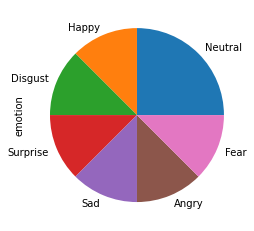

In [8]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='pie') 

In [9]:
df = pd.concat([SAVEE_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

Neutral     120
Sad         60 
Angry       60 
Happy       60 
Surprise    60 
Fear        60 
Disgust     60 
Name: labels, dtype: int64


In [10]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("./Data_path.csv")
ref.head(3)

,labels,source,path
0,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a01.wav
1,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a03.wav
2,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a02.wav


In [11]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['features'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    data, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=3
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)

    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    df.loc[counter] = [result]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

480


,features
0,"[0.017370746862934362, 0.5394400358200073, 0.5773108601570129, 0.6108185648918152, 0.5705168843269348, 0.5544029474258423, 0.5592149496078491, 0.5619054436683655, 0.5513596534729004, 0.5853631496429443, 0.6170016527175903, 0.5462908148765564, 0.49779626727104187, -332.5524597167969, 137.0924530029297, 23.122323989868164, 24.710020065307617, 27.274688720703125, 11.411749839782715, -1.7087957859039307, -21.02878761291504, -11.195062637329102, 4.841554641723633, -5.368484020233154, -8.832923889160156, -2.073859691619873, 0.14560768008232117, 9.905948638916016, 0.019427074119448662, 0.9923794269561768, 15.740214347839355, 25.861764907836914, 19.25112533569336, 13.024587631225586, 13.545265197753906, 42.92900085449219, 26.274812698364258, 43.43345642089844, 64.33880615234375, 101.64380645751953, 146.82574462890625, 55.298465728759766, 31.448627471923828, 35.15116500854492, 48.96223068237305, 21.132305145263672, 9.17074966430664, 11.491010665893555, 11.560911178588867, 5.9131951332092285, 3.1780340671539307, 2.566974401473999, 1.1216293573379517, 1.193328619003296, 1.2761975526809692, 1.4382007122039795, 0.8590383529663086, 0.32849568128585815, 0.5450328588485718, 0.5839126706123352, 0.3411184847354889, 0.3124929964542389, 0.33489882946014404, 0.39755669236183167, 0.18691697716712952, 0.13452313840389252, 0.2212522178888321, 0.18166743218898773, 0.07568764686584473, 0.13995946943759918, 0.19562244415283203, 0.16747482120990753, 0.17667272686958313, 0.24459208548069, 0.2970362901687622, 0.2507622241973877, 0.1845039427280426, 0.12824273109436035, 0.1403161734342575, 0.1455746740102768, 0.11934097111225128, 0.11041359603404999, 0.10653670132160187, 0.11046577990055084, 0.1618342399597168, 0.27720335125923157, 0.348051518201828, 0.23940497636795044, 0.198932483792305, 0.10532984137535095, 0.04452640935778618, 0.01448794361203909, 0.008773080073297024, 0.008186092600226402, 0.016820738092064857, 0.03130152076482773, 0.020757893100380898, 0.025754941627383232, 0.014532619155943394, 0.01564105600118637, ...]"
1,"[0.016504624310661766, 0.5110154151916504, 0.4930945634841919, 0.5716407299041748, 0.6135982871055603, 0.6327812671661377, 0.6464896202087402, 0.6228973269462585, 0.6435993909835815, 0.6188290119171143, 0.6401686072349548, 0.6259600520133972, 0.584302544593811, -337.9129943847656, 133.34674072265625, 9.782917022705078, 17.04794692993164, 23.90559196472168, 8.456602096557617, -2.819770336151123, -15.931432723999023, -0.7956457734107971, 9.550731658935547, -6.450502395629883, -7.063673973083496, 1.1432065963745117, 0.17969347536563873, 9.360223770141602, 0.013194717466831207, 0.05380788445472717, 3.471862316131592, 28.58749008178711, 72.95218658447266, 66.04354095458984, 16.045209884643555, 4.301520824432373, 22.546005249023438, 92.61625671386719, 125.30494689941406, 65.37187957763672, 85.79476928710938, 100.15923309326172, 83.81619262695312, 12.535225868225098, 20.160411834716797, 58.10558319091797, 67.7885513305664, 70.71331787109375, 43.36692428588867, 16.644216537475586, 8.613645553588867, 25.469097137451172, 17.37494659423828, 37.691200256347656, 34.95552444458008, 17.047395706176758, 5.8889689445495605, 4.727095603942871, 10.122650146484375, 5.276412487030029, 0.7618677020072937, 0.291938841342926, 0.8535251617431641, 2.8526248931884766, 2.068253517150879, 0.5867685675621033, 0.36270231008529663, 0.877716600894928, 2.371711254119873, 1.6072139739990234, 0.631868839263916, 0.4854336380958557, 0.8363161087036133, 0.3060082793235779, 0.39222297072410583, 0.8085960745811462, 1.0430539846420288, 0.6114866137504578, 0.31019946932792664, 0.3045773208141327, 0.29563453793525696, 0.3482738435268402, 0.4022561013698578, 0.31965890526771545, 0.49462199211120605, 0.6677675247192383, 0.685797929763794, 1.359269142150879, 2.1491594314575195, 1.5615516901016235, 1.0128127336502075, 0.4383108913898468, 0.16342982649803162, 0.061408814042806625, 0.04337936267256737, 0.008367050439119339, 0.00407766830176115, 0.0028569246642291546,

In [12]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['features'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a01.wav,0.017371,0.539440,0.577311,0.610819,0.570517,0.554403,0.559215,0.561905,0.551360,0.585363,0.617002,0.546291,0.497796,-332.552460,137.092453,23.122324,24.710020,27.274689,11.411750,-1.708796,-21.028788,-11.195063,4.841555,-5.368484,-8.832924,-2.073860,0.145608,9.905949,0.019427,0.992379,15.740214,25.861765,19.251125,13.024588,13.545265,42.929001,26.274813,...,0.012609,0.007122,0.002623,0.001296,0.000579,0.000492,0.000492,0.000363,0.000191,0.000083,0.000025,0.000004,4.156139e-07,1.112467e-07,1.010603e-07,1.431140e-07,1.481340e-07,1.206542e-07,7.528619e-08,6.206089e-08,6.678672e-08,6.100191e-08,6.547577e-08,5.613373e-08,4.633876e-08,4.048207e-08,4.014733e-08,3.844170e-08,3.441223e-08,4.639330e-08,4.016162e-08,4.139129e-08,2.311899e-08,2.022906e-08,1.818396e-08,1.670629e-08,1.745404e-08,1.427437e-08,1.350166e-08,1.261343e-08
1,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a03.wav,0.016505,0.511015,0.493095,0.571641,0.613598,0.632781,0.646490,0.622897,0.643599,0.618829,0.640169,0.625960,0.584303,-337.912994,133.346741,9.782917,17.047947,23.905592,8.456602,-2.819770,-15.931433,-0.795646,9.550732,-6.450502,-7.063674,1.143207,0.179693,9.360224,0.013195,0.053808,3.471862,28.587490,72.952187,66.043541,16.045210,4.301521,22.546005,...,0.003168,0.002237,0.001455,0.001717,0.000782,0.000729,0.000410,0.000239,0.000142,0.000059,0.000017,0.000005,1.621112e-06,1.268563e-06,1.196169e-06,1.185115e-06,1.223231e-06,1.232995e-06,1.135555e-06,1.052364e-06,1.029698e-06,1.033231e-06,9.212267e-07,7.903410e-07,7.674778e-07,7.177861e-07,6.222155e-07,5.260250e-07,4.675750e-07,4.390588e-07,3.521781e-07,3.070122e-07,2.548526e-07,2.188118e-07,1.915702e-07,1.744468e-07,1.659255e-07,1.689194e-07,1.726148e-07,1.655735e-07
2,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a02.wav,0.014820,0.689377,0.739959,0.714980,0.661562,0.599631,0.553784,0.519458,0.533781,0.588738,0.643539,0.586577,0.577857,-307.238129,143.947098,14.212210,3.526977,20.336990,13.365442,-0.540856,-15.662713,-4.573224,11.443162,-1.732389,-8.534613,2.792009,0.138990,9.368910,0.027119,1.181760,21.788958,32.031143,12.774037,12.605021,19.275064,66.901054,32.935806,...,0.002062,0.001601,0.000745,0.000475,0.000142,0.000090,0.000056,0.000057,0.000060,0.000025,0.000005,0.000001,6.155689e-07,4.136182e-07,2.830057e-07,1.989617e-07,1.281959e-07,2.000448e-07,3.004090e-07,1.736067e-07,6.218462e-08,8.522264e-08,9.658897e-08,1.695551e-07,5.227377e-08,1.004885e-07,9.414452e-08,7.667255e-08,7.061963e-08,3.050544e-07,1.132345e-07,1.487029e-07,4.805051e-08,2.087095e-08,3.383651e-08,2.572526e-08,2.591456e-08,1.493258e-08,1.162054e-08,1.681612e-08
3,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a04.wav,0.024371,0.562070,0.541375,0.563710,0.608891,0.635115,0.654574,0.575800,0.506037,0.538889,0.561398,0.548258,0.541386,-298.634705,123.939850,22.005791,13.159058,14.783544,7.862321,-0.928133,-21.256918,-14.658116,2.996278,-4.968653,-8.594079,-0.742083,0.167929,1.354858,0.065133,1.095046,8.731604,27.586197,25.646126,17.802992,19.242966,18.453302,30.930695,...,0.005326,0.004255,0.001864,0.001115,0.000353,0.000276,0.000348,0.000257,0.000144,0.000089,0.000032,0.000019,1.255889e-05,8.353940e-06,7.471568e-06,5.784590e-06,4.958940e-06,3.988587e-06,4.584515e-06,4.339526e-06,3.598276e-06,3.196718e-06,2.273014e-06,3.493643e-06,2.685753e-06,3.702453e-06,2.343880e-06,2.638189e-06,2.153935e-06,7.340613e-06,2.360253e-06,2.753423e-06,1.472350e-06,1.289091e-06,6.732154e-07,6.298046e-07,6.759909e-07,3.577002e-07,3.631881e-07,3.558510e-07
4,Angry,S

In [13]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(480, 158)


,labels,source,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a01.wav,0.017371,0.539440,0.577311,0.610819,0.570517,0.554403,0.559215,0.561905,0.551360,0.585363,0.617002,0.546291,0.497796,-332.552460,137.092453,23.122324,24.710020,27.274689,11.411750,-1.708796,-21.028788,-11.195063,4.841555,-5.368484,-8.832924,-2.073860,0.145608,9.905949,0.019427,0.992379,15.740214,25.861765,19.251125,13.024588,13.545265,42.929001,26.274813,...,0.012609,0.007122,0.002623,0.001296,0.000579,0.000492,0.000492,0.000363,0.000191,0.000083,0.000025,0.000004,4.156139e-07,1.112467e-07,1.010603e-07,1.431140e-07,1.481340e-07,1.206542e-07,7.528619e-08,6.206089e-08,6.678672e-08,6.100191e-08,6.547577e-08,5.613373e-08,4.633876e-08,4.048207e-08,4.014733e-08,3.844170e-08,3.441223e-08,4.639330e-08,4.016162e-08,4.139129e-08,2.311899e-08,2.022906e-08,1.818396e-08,1.670629e-08,1.745404e-08,1.427437e-08,1.350166e-08,1.261343e-08
1,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a03.wav,0.016505,0.511015,0.493095,0.571641,0.613598,0.632781,0.646490,0.622897,0.643599,0.618829,0.640169,0.625960,0.584303,-337.912994,133.346741,9.782917,17.047947,23.905592,8.456602,-2.819770,-15.931433,-0.795646,9.550732,-6.450502,-7.063674,1.143207,0.179693,9.360224,0.013195,0.053808,3.471862,28.587490,72.952187,66.043541,16.045210,4.301521,22.546005,...,0.003168,0.002237,0.001455,0.001717,0.000782,0.000729,0.000410,0.000239,0.000142,0.000059,0.000017,0.000005,1.621112e-06,1.268563e-06,1.196169e-06,1.185115e-06,1.223231e-06,1.232995e-06,1.135555e-06,1.052364e-06,1.029698e-06,1.033231e-06,9.212267e-07,7.903410e-07,7.674778e-07,7.177861e-07,6.222155e-07,5.260250e-07,4.675750e-07,4.390588e-07,3.521781e-07,3.070122e-07,2.548526e-07,2.188118e-07,1.915702e-07,1.744468e-07,1.659255e-07,1.689194e-07,1.726148e-07,1.655735e-07
2,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a02.wav,0.014820,0.689377,0.739959,0.714980,0.661562,0.599631,0.553784,0.519458,0.533781,0.588738,0.643539,0.586577,0.577857,-307.238129,143.947098,14.212210,3.526977,20.336990,13.365442,-0.540856,-15.662713,-4.573224,11.443162,-1.732389,-8.534613,2.792009,0.138990,9.368910,0.027119,1.181760,21.788958,32.031143,12.774037,12.605021,19.275064,66.901054,32.935806,...,0.002062,0.001601,0.000745,0.000475,0.000142,0.000090,0.000056,0.000057,0.000060,0.000025,0.000005,0.000001,6.155689e-07,4.136182e-07,2.830057e-07,1.989617e-07,1.281959e-07,2.000448e-07,3.004090e-07,1.736067e-07,6.218462e-08,8.522264e-08,9.658897e-08,1.695551e-07,5.227377e-08,1.004885e-07,9.414452e-08,7.667255e-08,7.061963e-08,3.050544e-07,1.132345e-07,1.487029e-07,4.805051e-08,2.087095e-08,3.383651e-08,2.572526e-08,2.591456e-08,1.493258e-08,1.162054e-08,1.681612e-08
3,Angry,SAVEE,/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/AudioData/DC_a04.wav,0.024371,0.562070,0.541375,0.563710,0.608891,0.635115,0.654574,0.575800,0.506037,0.538889,0.561398,0.548258,0.541386,-298.634705,123.939850,22.005791,13.159058,14.783544,7.862321,-0.928133,-21.256918,-14.658116,2.996278,-4.968653,-8.594079,-0.742083,0.167929,1.354858,0.065133,1.095046,8.731604,27.586197,25.646126,17.802992,19.242966,18.453302,30.930695,...,0.005326,0.004255,0.001864,0.001115,0.000353,0.000276,0.000348,0.000257,0.000144,0.000089,0.000032,0.000019,1.255889e-05,8.353940e-06,7.471568e-06,5.784590e-06,4.958940e-06,3.988587e-06,4.584515e-06,4.339526e-06,3.598276e-06,3.196718e-06,2.273014e-06,3.493643e-06,2.685753e-06,3.702453e-06,2.343880e-06,2.638189e-06,2.153935e-06,7.340613e-06,2.360253e-06,2.753423e-06,1.472350e-06,1.289091e-06,6.732154e-07,6.298046e-07,6.759909e-07,3.577002e-07,3.631881e-07,3.558510e-07
4,Angry,S

In [14]:
# Split between train and test 
x_train, x_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
x_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
69,0.006572,0.735220,0.715748,0.687544,0.667604,0.650252,0.617675,0.568543,0.547136,0.553855,0.601423,0.648315,0.694423,-454.569122,140.009186,37.760838,25.094418,35.957989,23.931358,-0.190056,-15.531553,-1.818831,9.907432,-2.141642,-8.046530,-0.855056,0.064533,9.409070,0.062792,0.928491,3.589206,3.435093,1.190777,3.251441,6.389059,8.903593,3.175704,4.357674,3.795822,2.814459,...,0.000999,0.000640,0.000193,0.000059,0.000027,0.000024,0.000029,9.239870e-06,4.361822e-06,1.829009e-06,7.896925e-07,2.674959e-07,2.488565e-08,9.390352e-09,8.743070e-09,1.173489e-08,1.322577e-08,1.212112e-08,8.399484e-09,7.181831e-09,8.167673e-09,8.307742e-09,7.891856e-09,8.700748e-09,7.244950e-09,6.483603e-09,6.717157e-09,6.612111e-09,6.782168e-09,7.886084e-09,8.403902e-09,8.007190e-09,6.674176e-09,6.278851e-09,6.539343e-09,6.317287e-09,6.650078e-09,6.181986e-09,6.093301e-09,6.367224e-09
450,0.015334,0.604705,0.582940,0.563807,0.562619,0.585159,0.550612,0.581531,0.632625,0.689950,0.698150,0.676756,0.621189,-623.433899,124.397163,40.789841,31.541004,33.626682,11.726497,-6.557689,-7.676266,0.828808,1.317178,-3.291805,-2.645794,-4.718603,0.006520,0.012012,0.001475,0.023626,0.056942,0.037224,0.014661,0.032772,0.070276,0.111607,0.289720,0.418020,0.074919,0.049927,...,0.000008,0.000004,0.000005,0.000003,0.000003,0.000002,0.000001,8.413729e-07,2.795953e-07,1.416972e-07,6.559376e-08,2.241804e-08,9.606835e-09,7.659139e-09,7.240290e-09,6.881238e-09,6.984486e-09,6.674596e-09,6.735793e-09,6.164382e-09,6.369821e-09,6.306291e-09,6.495395e-09,6.771846e-09,6.428025e-09,5.816820e-09,5.748426e-09,5.880142e-09,5.775671e-09,5.781670e-09,5.500502e-09,5.691482e-09,5.866685e-09,5.943498e-09,5.942860e-09,5.816546e-09,5.719588e-09,5.802292e-09,5.658881e-09,6.016080e-09
123,0.033474,0.532632,0.535844,0.586282,0.615454,0.650731,0.651074,0.643192,0.595765,0.569975,0.560145,0.598332,0.592086,-283.975403,115.682335,4.605017,27.824198,19.710796,0.440821,2.844468,-15.130561,-12.193137,-1.874628,-7.398972,-1.475096,-1.097986,0.186425,1.087947,0.059816,1.111869,25.370533,93.653046,93.449577,67.162544,75.988388,78.860321,66.093956,122.734650,121.686684,68.083916,...,0.021681,0.009471,0.005814,0.004444,0.004277,0.002316,0.001743,1.022344e-03,6.700598e-04,3.191506e-04,1.071214e-04,3.524770e-05,1.780402e-05,1.304178e-05,1.325304e-05,1.105243e-05,8.449423e-06,8.153484e-06,7.788308e-06,6.159048e-06,4.543765e-06,3.363854e-06,4.585576e-06,4.820797e-06,6.499539e-06,4.688771e-06,3.422750e-06,3.263786e-06,4.139012e-06,1.306560e-05,3.653692e-06,4.141602e-06,2.052402e-06,2.271763e-06,1.002578e-06,8.764342e-07,7.020159e-07,6.465215e-07,5.569697e-07,4.757919e-07
355,0.023031,0.645358,0.621640,0.611832,0.590050,0.608417,0.598460,0.549932,0.554155,0.587899,0.629293,0.594620,0.625490,-549.050049,104.959274,33.903679,20.413040,18.207041,8.966290,1.544151,-7.742290,-6.844403,-2.232239,-6.051897,-6.503314,-4.323145,0.010498,0.013667,0.001854,0.014794,0.081180,0.081248,0.055681,0.126870,0.149688,0.368739,0.166737,0.198551,0.281690,0.897556,...,0.000026,0.000007,0.000016,0.000012,0.000009,0.000008,0.000004,1.343140e-06,3.819639e-07,1.828767e-07,1.196977e-07,4.788657e-08,1.283340e-08,7.917621e-09,7.536460e-09,7.410525e-09,7.277011e-09,6.754727e-09,6.556411e-09,6.900264e-09,6.815450e-09,6.556940e-09,6.866615e-09,8.023194e-09,6.636313e-09,6.009897e-09,6.321028e-09,5.929944e-09,6.101539e-09,6.339735e-09,6.235157e-09,6.349383e-09,6.407971e-09,6.134901e-09,5.997931e-09,5.953432e-09,6.090577e-09,5.921873e-09,5.963929e-09,6.193740e-09
96,0.011214,0.347940,0.488652,0.530777,0.413830,0.449124,0.616471,0.777686,0.796877,0.556108,0.403554,0.328985,0.313481,-381.200256,137.204056,29.737480,19.363503,24.043953,16.835840,3.227619,-19.788605,-11.167689,6

In [15]:
# Lts do data normalization 
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

# Check the dataset now 
x_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
69,-1.000193,1.782444,1.721303,1.543653,1.408679,1.096676,0.468070,-0.086036,-0.277591,-0.361283,0.127731,0.746800,1.364825,-0.269911,0.271878,0.946329,-0.374709,1.198210,1.876212,0.195280,-0.759330,0.586730,1.640645,0.963181,-0.784899,0.053291,-0.505800,0.950432,-0.074985,0.000955,-0.305201,-0.490703,-0.688576,-0.632758,-0.506679,-0.453535,-0.494864,-0.523742,-0.534455,-0.529244,...,-0.466479,-0.453203,-0.425044,-0.405111,-0.411969,-0.418497,-0.429676,-0.445220,-0.454139,-0.446337,-0.396647,-0.324662,-0.266474,-0.266121,-0.264968,-0.265754,-0.258740,-0.255949,-0.258600,-0.271090,-0.281873,-0.277670,-0.276273,-0.284415,-0.271505,-0.270790,-0.237895,-0.262871,-0.252013,-0.269995,-0.287279,-0.278892,-0.260235,-0.248978,-0.239127,-0.263070,-0.275763,-0.279466,-0.283339,-0.275169
450,-0.111061,0.223435,0.074022,-0.040782,0.048244,0.235792,-0.448878,0.094917,0.863149,1.481509,1.399376,1.102258,0.463289,-1.591530,-0.576822,1.132042,0.290182,0.941695,0.776133,-0.781315,0.307442,1.009820,0.246381,0.712749,0.164933,-1.128780,-1.261455,-1.180950,-0.140523,-0.642457,-0.611793,-0.630352,-0.733772,-0.724528,-0.663744,-0.618990,-0.571144,-0.585904,-0.589533,-0.560215,...,-0.521187,-0.506149,-0.446359,-0.412953,-0.416412,-0.423723,-0.440077,-0.450929,-0.459646,-0.451130,-0.400951,-0.327778,-0.266790,-0.266172,-0.265025,-0.265982,-0.259072,-0.256274,-0.258713,-0.271170,-0.282028,-0.277856,-0.276403,-0.284603,-0.271588,-0.270869,-0.237991,-0.262949,-0.252088,-0.270099,-0.287719,-0.279170,-0.260390,-0.249049,-0.239309,-0.263300,-0.276318,-0.279729,-0.283677,-0.275464
123,1.729792,-0.637488,-0.510133,0.247006,0.732908,1.103004,0.924732,0.954035,0.371304,-0.143003,-0.414951,0.122128,0.105019,1.065239,-1.050577,-1.086506,-0.093163,-0.589478,-0.241095,0.660680,-0.704874,-1.071071,-0.271673,-0.181529,0.370825,-0.021034,1.081926,-0.936913,-0.078166,0.131348,1.585360,3.217161,2.856712,1.189455,1.223333,0.862970,1.168141,1.344066,1.210578,0.201980,...,0.675083,0.282334,0.211547,0.210837,0.378229,0.141270,0.221856,0.243469,0.443978,0.454978,0.235347,0.119989,0.101280,0.118509,0.235056,0.251092,0.189527,0.230266,0.271967,0.214995,0.109680,0.035382,0.148751,0.184257,0.384179,0.287833,0.102976,0.083112,0.053662,0.377174,0.266148,0.215600,0.134203,0.231136,0.065113,0.135848,0.138937,0.164280,0.145889,0.119835
355,0.670109,0.709036,0.554033,0.574165,0.403706,0.543395,0.205342,-0.345343,-0.183923,0.099696,0.494124,0.075737,0.516238,-1.009365,-1.633504,0.709840,-0.857539,-0.754937,0.527343,0.461252,0.298476,-0.216350,-0.329716,0.111778,-0.513493,-1.007788,-1.209632,-1.180575,-0.140118,-0.648736,-0.609689,-0.628542,-0.732196,-0.721845,-0.661770,-0.614151,-0.574395,-0.589367,-0.586472,-0.550719,...,-0.520201,-0.505938,-0.445072,-0.411631,-0.415303,-0.422377,-0.439200,-0.450588,-0.459508,-0.451013,-0.400629,-0.327454,-0.266723,-0.266165,-0.265013,-0.265957,-0.259056,-0.256269,-0.258726,-0.271112,-0.281990,-0.277833,-0.276368,-0.284481,-0.271567,-0.270846,-0.237934,-0.262944,-0.252064,-0.270071,-0.287608,-0.279091,-0.260286,-0.249008,-0.239292,-0.263237,-0.276096,-0.279647,-0.283439,-0.275315
96,-0.529174,-2.843641,-1.095479,-0.463739,-1.879812,-1.563319,0.451600,2.827918,3.054882,-0.330764,-2.473621,-3.244122,-3.324702,0.304309,0.119386,0.454404,-0.965786,-0.112698,1.236661,0.719444,-1.337451,-0.907206,1.116113,0.169592,-1.276029,0.877470,-0.139641,0.872441,-0.136797,-0.655260,-0.596588,-0.268803,0.619612,-0.263081,-0.654941,-0.618726,-0.566844,-0.358418,0.056234,-0.212752,...,-0.389793,-0.444102,-0.377207,-0.372565,-0.394583,-0.403966,-0.412913,-0.418278,-0.426857,-0.421168,-0.380534,-0.320281,-0.265800,-0.266005,-0.264798,-0.265539,-0.258276,-0.255699,-0.258410,-0.270996,-0.281627,-0.277382,

In [16]:

# TRAIN TEST SPLIT DATA
#train,test = train_test_split(df_combined, test_size=0.20, random_state=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
(384, 155, 1)
(96, 155, 1)


(480, 7)

In [17]:
lb.classes_

array(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
      dtype=object)

In [ ]:
 
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(5),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_189 (Conv1D)          (None, 259, 256)          2304      
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 252, 256)          524544    
_________________________________________________________________
max_pooling1d_165 (MaxPoolin (None, 126, 256)          0         
_________________________________________________________________
batch_normalization_163 (Bat (None, 126, 256)          1024      
_________________________________________________________________
dropout_205 (Dropout)        (None, 126, 256)          0         
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 126, 256)          524544    
_________________________________________________________________
max_pooling1d_166 (MaxPoolin (None, 63, 256)         

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(7, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
  model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Streaming output truncated to the last 5000 lines.
Epoch 775/1000
8/8 [==============================] - 0s 29ms/step - loss: 0.0762 - accuracy: 0.9811 - val_loss: 2.5419 - val_accuracy: 0.6875

Epoch 00775: val_accuracy did not improve from 0.77083
Epoch 776/1000
8/8 [==============================] - 0s 30ms/step - loss: 0.0801 - accuracy: 0.9880 - val_loss: 2.7117 - val_accuracy: 0.7188

Epoch 00776: val_accuracy did not improve from 0.77083
Epoch 777/1000
8/8 [==============================] - 0s 29ms/step - loss: 0.1407 - accuracy: 0.9566 - val_loss: 2.1732 - val_accuracy: 0.6979

Epoch 00777: val_accuracy did not improve from 0.77083
Epoch 778/1000
8/8 [==============================] - 0s 30ms/step - loss: 0.1323 - accuracy: 0.9842 - val_loss: 1.9099 - val_accuracy: 0.7396

Epoch 00778: val_accuracy did not improve from 0.77083
Epoch 779/1000
8/8 [==============================] - 0s 30ms/step - loss: 0.1201 - accuracy: 0.9703 - val_loss: 1.8859 - val_accuracy: 0.7500

Epoch 007

4/4 [==============================] - 0s 10ms/step - loss: 2.7272 - accuracy: 0.7083
Loss of the model is -  2.727234363555908
4/4 [==============================] - 0s 9ms/step - loss: 2.7272 - accuracy: 0.7083
Accuracy of the model is -  70.83333134651184 %


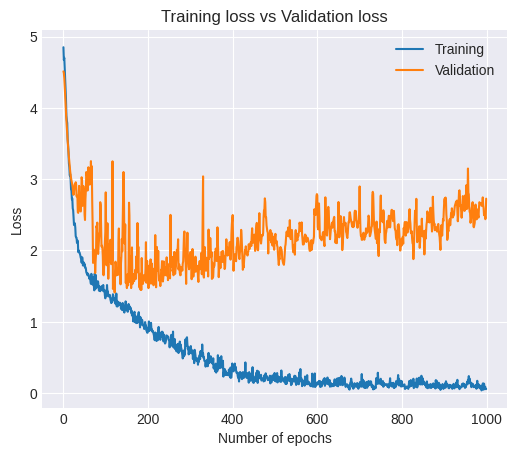

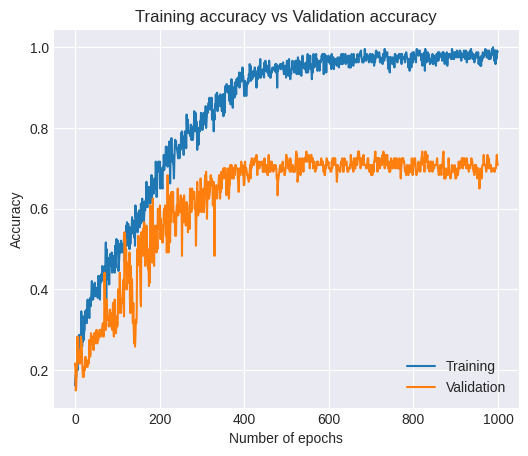

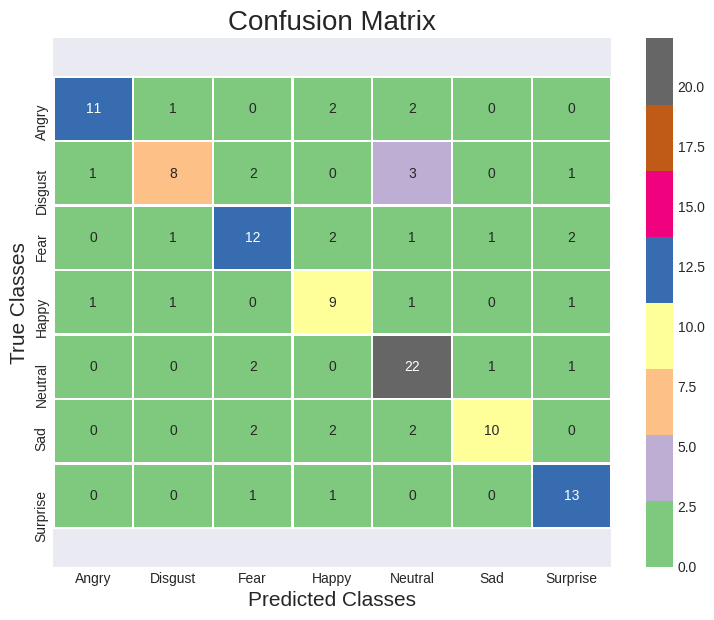

              precision    recall  f1-score   support

       Angry       0.85      0.69      0.76        16
     Disgust       0.73      0.53      0.62        15
        Fear       0.63      0.63      0.63        19
       Happy       0.56      0.69      0.62        13
     Neutral       0.71      0.85      0.77        26
         Sad       0.83      0.62      0.71        16
    Surprise       0.72      0.87      0.79        15

    accuracy                           0.71       120
   macro avg       0.72      0.70      0.70       120
weighted avg       0.72      0.71      0.71       120



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise'])) 

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
df_mel = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    # Mel-frequency cepstral coefficients (MFCCs)
#     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#     mfcc=np.mean(mfcc,axis=0)
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df_mel.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df_mel))
df_mel.head()

480


,mel_spectrogram
0,"[-44.402214, -43.969547, -43.880775, -43.48654, -43.61068, -43.632847, -43.61963, -43.726906, -43.468693, -43.614796, -43.677956, -43.608776, -43.635387, -41.87462, -38.562252, -36.452034, -34.63321, -29.091389, -24.163797, -25.138943, -31.310404, -35.13452, -36.89921, -38.194458, -39.568134, -40.045948, -25.874424, -15.666957, -13.551947, -16.018969, -17.467987, -17.999695, -19.486353, -20.997406, -22.696138, -22.109081, -22.411045, -22.35584, -21.513643, -21.088861, -22.622873, -24.09499, -22.999048, -22.280552, -20.358084, -18.429071, -19.562675, -24.993668, -31.431273, -35.655247, -36.905144, -29.947906, -23.295725, -20.975918, -18.915781, -18.770748, -21.046743, -22.43431, -23.194744, -23.118916, -22.89234, -22.293005, -22.433075, -22.415712, -22.891048, -23.18818, -23.127811, -21.920317, -20.65932, -20.198633, -21.298883, -22.395407, -23.062298, -23.082714, -25.596134, -32.730354, -36.229744, -39.18281, -42.50985, -43.710094, -44.252415, -43.498127, -38.93486, -35.77768, -33.275707, -31.225918, -29.39349, -27.493874, -25.196089, -20.716755, -19.433912, -19.984877, -23.635317, -29.957258, -33.258194, -35.234577, -36.72787, -38.355885, -40.000317, -41.679863, ...]"
1,"[-46.747425, -46.22411, -46.525356, -46.286392, -45.470398, -39.11999, -33.960052, -31.53631, -30.162855, -31.034214, -34.14362, -35.478798, -33.015797, -28.428526, -23.786587, -21.683817, -21.379702, -22.222702, -24.585562, -26.05232, -26.991817, -29.515436, -31.462566, -33.150864, -34.58235, -35.361168, -29.053679, -19.866423, -16.753876, -16.34156, -18.416239, -19.998814, -20.569897, -20.306116, -20.503605, -21.802107, -22.786146, -22.948318, -23.318956, -23.291363, -23.700039, -26.428215, -28.576689, -29.476921, -30.009321, -29.882072, -25.902082, -22.91177, -21.413818, -20.55321, -19.266268, -19.222797, -19.413147, -20.91045, -21.80768, -22.927164, -23.467258, -24.393957, -25.330898, -25.068289, -25.09756, -24.588614, -23.046577, -20.966503, -18.945717, -17.917698, -17.353828, -18.098167, -18.963802, -20.932434, -23.329601, -26.665564, -30.122324, -32.930153, -35.22325, -37.93996, -39.732086, -40.96561, -42.386818, -44.26905, -45.521366, -45.291695, -38.38033, -32.15121, -27.482988, -24.108797, -22.145166, -21.152988, -21.440596, -22.254564, -22.825043, -23.757275, -24.437279, -25.387976, -27.324707, -32.03041, -37.840218, -40.125874, -38.534218, -37.582615, ...]"
2,"[-29.09731, -17.569803, -13.849436, -14.865465, -15.829715, -16.042406, -16.083738, -15.757243, -18.032864, -21.22581, -23.737886, -22.277826, -20.756502, -21.801878, -23.442057, -23.109406, -24.446285, -29.92582, -39.02166, -43.28907, -45.94705, -36.062294, -30.365421, -28.537403, -27.419388, -26.912868, -29.226522, -35.907314, -40.976883, -43.77351, -45.52094, -47.056667, -47.983887, -48.576668, -49.01528, -49.57729, -46.7475, -35.36526, -27.59451, -25.419544, -24.395853, -24.977236, -26.246696, -26.97909, -27.090738, -28.014389, -28.65673, -28.78218, -29.113989, -29.113369, -29.312021, -29.222034, -28.336601, -27.956533, -28.058075, -28.195065, -29.418533, -34.054707, -40.121613, -42.890236, -44.914814, -39.698208, -32.906837, -31.62619, -31.726065, -31.679825, -30.98342, -29.900726, -31.059547, -33.18199, -34.089153, -35.223175, -36.11138, -37.16474, -39.25767, -40.06684, -33.62668, -28.837187, -27.449732, -27.192749, -26.852436, -26.169748, -25.18573, -23.40322, -21.770435, -20.757822, -20.269453, -21.145662, -23.405985, -23.38635, -20.89318, -19.449955, -19.020344, -18.817186, -18.393934, -19.754494, -21.992558, -24.86257, -30.297384, -35.226692, ...]"
3,"[-39.892082, -36.421288, -33.5116, -30.752447, -28.684849, -27.572443, -27.592028, -27.712822, -24.537973, -22.30922, -21.964943, -21.775118, -20.921747, -21.338179, -22.91919, -26.266766, -30.748716, -34.19785, -35.858574, -37.357246, -39.46718, -40.791138, -42.088177, -32.98475, -28.326092, -26.209833, -23.851698, -21.205492, -20.91266, -22.331133, -23.897934, -23.849342, -24.921303, -30.087639, -34.198895, -31.6

In [ ]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df_mel['mel_spectrogram'].values.tolist())],axis=1)
df[:5]

# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]


# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.20, random_state=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

(480, 262)
[[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
(360, 259, 1)
(120, 259, 1)


(480, 7)

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(7, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
  model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Streaming output truncated to the last 5000 lines.
Epoch 775/1000
8/8 [==============================] - 0s 34ms/step - loss: 0.3569 - accuracy: 0.9075 - val_loss: 1.5750 - val_accuracy: 0.7083

Epoch 00775: val_accuracy did not improve from 0.76667
Epoch 776/1000
8/8 [==============================] - 0s 32ms/step - loss: 0.2946 - accuracy: 0.9184 - val_loss: 1.5229 - val_accuracy: 0.7500

Epoch 00776: val_accuracy did not improve from 0.76667
Epoch 777/1000
8/8 [==============================] - 0s 29ms/step - loss: 0.2604 - accuracy: 0.9145 - val_loss: 1.5516 - val_accuracy: 0.7333

Epoch 00777: val_accuracy did not improve from 0.76667
Epoch 778/1000
8/8 [==============================] - 0s 32ms/step - loss: 0.2010 - accuracy: 0.9500 - val_loss: 1.6437 - val_accuracy: 0.7417

Epoch 00778: val_accuracy did not improve from 0.76667
Epoch 779/1000
8/8 [==============================] - 0s 30ms/step - loss: 0.2721 - accuracy: 0.9192 - val_loss: 1.7268 - val_accuracy: 0.7167

Epoch 007

4/4 [==============================] - 0s 10ms/step - loss: 2.8008 - accuracy: 0.6667
Loss of the model is -  2.8008272647857666
4/4 [==============================] - 0s 10ms/step - loss: 2.8008 - accuracy: 0.6667
Accuracy of the model is -  66.66666865348816 %


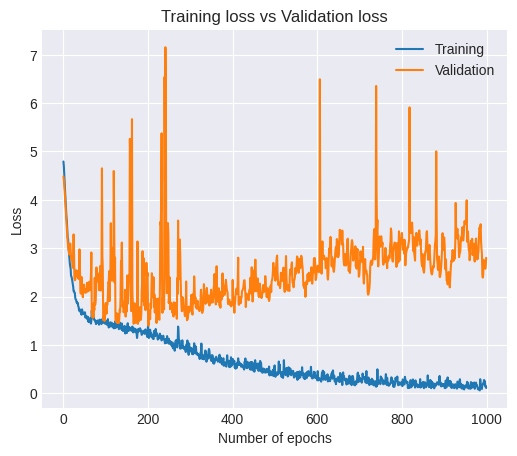

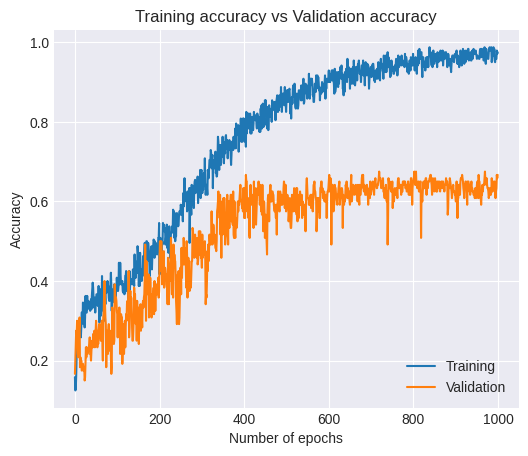

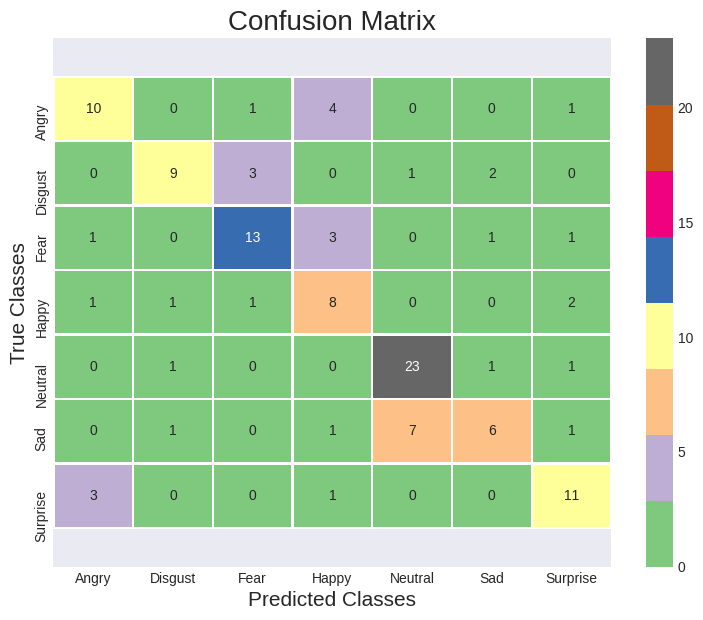

              precision    recall  f1-score   support

       Angry       0.67      0.62      0.65        16
     Disgust       0.75      0.60      0.67        15
        Fear       0.72      0.68      0.70        19
       Happy       0.47      0.62      0.53        13
     Neutral       0.74      0.88      0.81        26
         Sad       0.60      0.38      0.46        16
    Surprise       0.65      0.73      0.69        15

    accuracy                           0.67       120
   macro avg       0.66      0.65      0.64       120
weighted avg       0.67      0.67      0.66       120



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']))  

In [12]:
#ENSEMBLE-WITHOUT AUGMENTATION

In [19]:
model1 = tf.keras.Sequential()
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization()) 
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(7, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model1.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model1.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model1.save('/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/model1-CNN-savee-without-augmentation.hdf5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 155, 256)          2304      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 74, 256)           1024      
_________________________________________________________________
dropout_10 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 37, 256)          

3/3 [==============================] - 0s 12ms/step - loss: 4.6139 - accuracy: 0.6771
Loss of the model is -  4.613875865936279
3/3 [==============================] - 0s 12ms/step - loss: 4.6139 - accuracy: 0.6771
Accuracy of the model is -  67.70833134651184 %


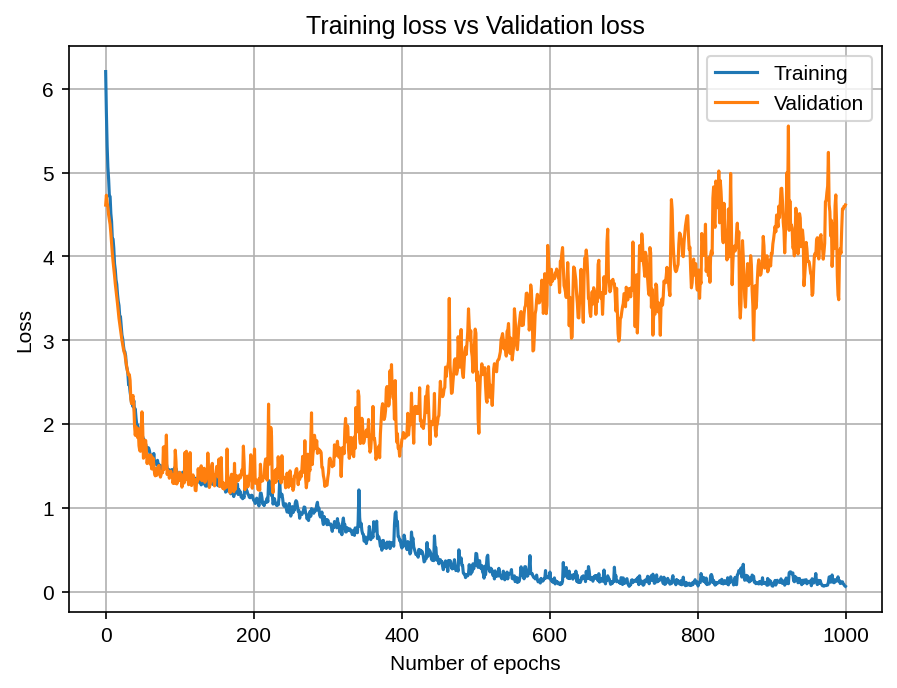

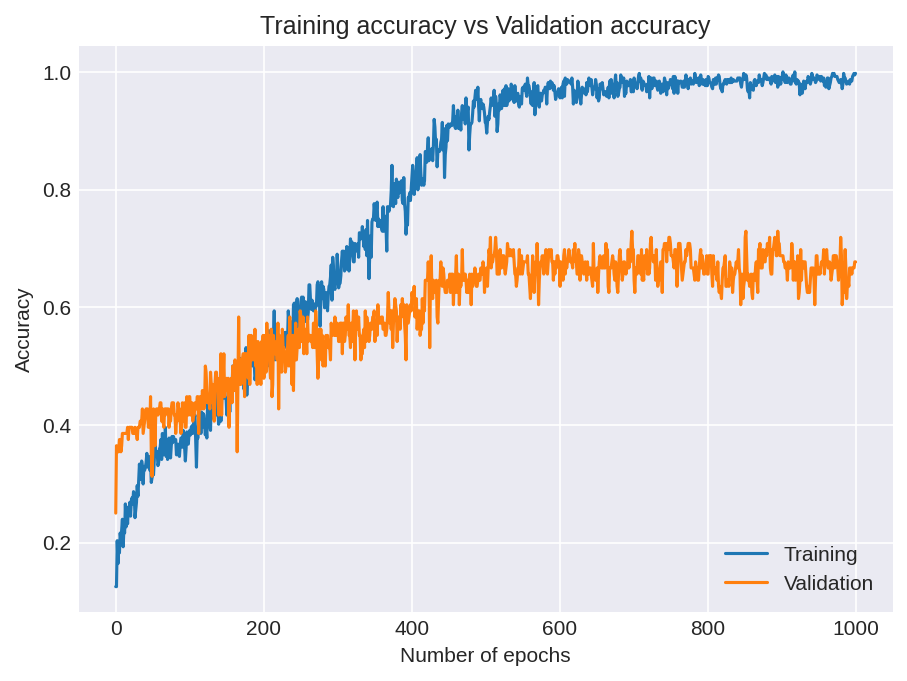

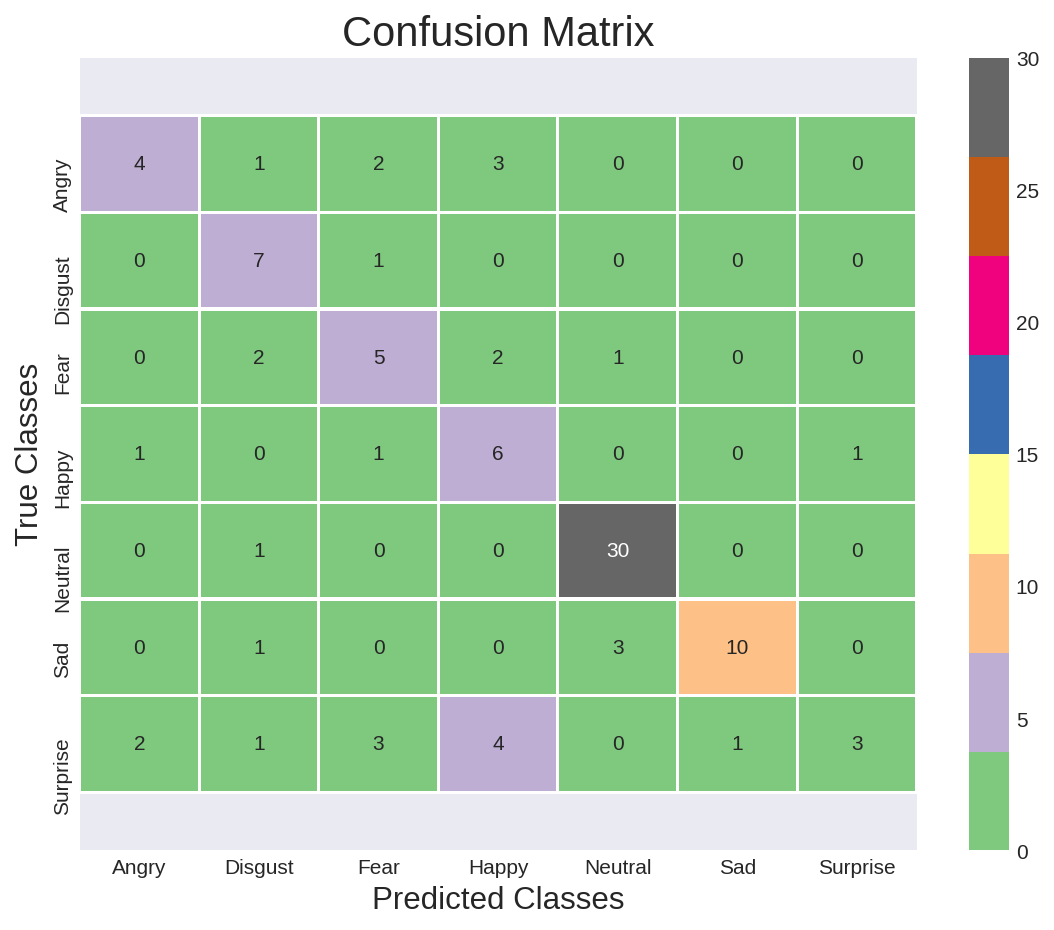

              precision    recall  f1-score   support

       Angry       0.57      0.40      0.47        10
     Disgust       0.54      0.88      0.67         8
        Fear       0.42      0.50      0.45        10
       Happy       0.40      0.67      0.50         9
     Neutral       0.88      0.97      0.92        31
         Sad       0.91      0.71      0.80        14
    Surprise       0.75      0.21      0.33        14

    accuracy                           0.68        96
   macro avg       0.64      0.62      0.59        96
weighted avg       0.71      0.68      0.66        96



In [20]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs') 
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model1.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']))  

In [21]:
model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.LSTM(512))
model2.add(layers.Dropout(0.5))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(7, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model2.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model2.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model2.save('/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/model2-LSTM-savee-without-augmentation.hdf5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_20 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 37, 256)          

3/3 [==============================] - 0s 13ms/step - loss: 2.7143 - accuracy: 0.6562
Loss of the model is -  2.714336395263672
3/3 [==============================] - 0s 14ms/step - loss: 2.7143 - accuracy: 0.6562
Accuracy of the model is -  65.625 %


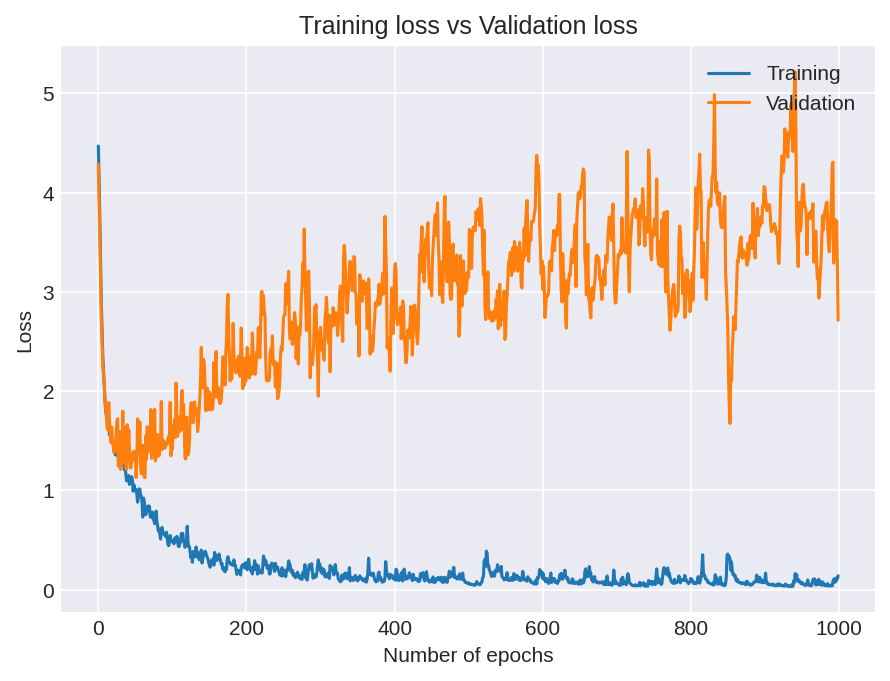

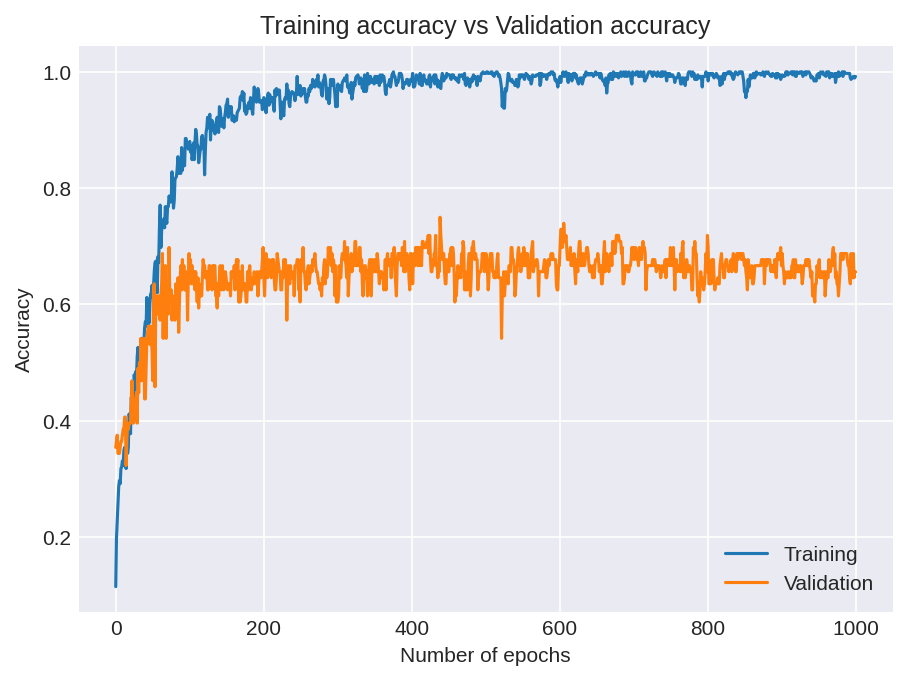

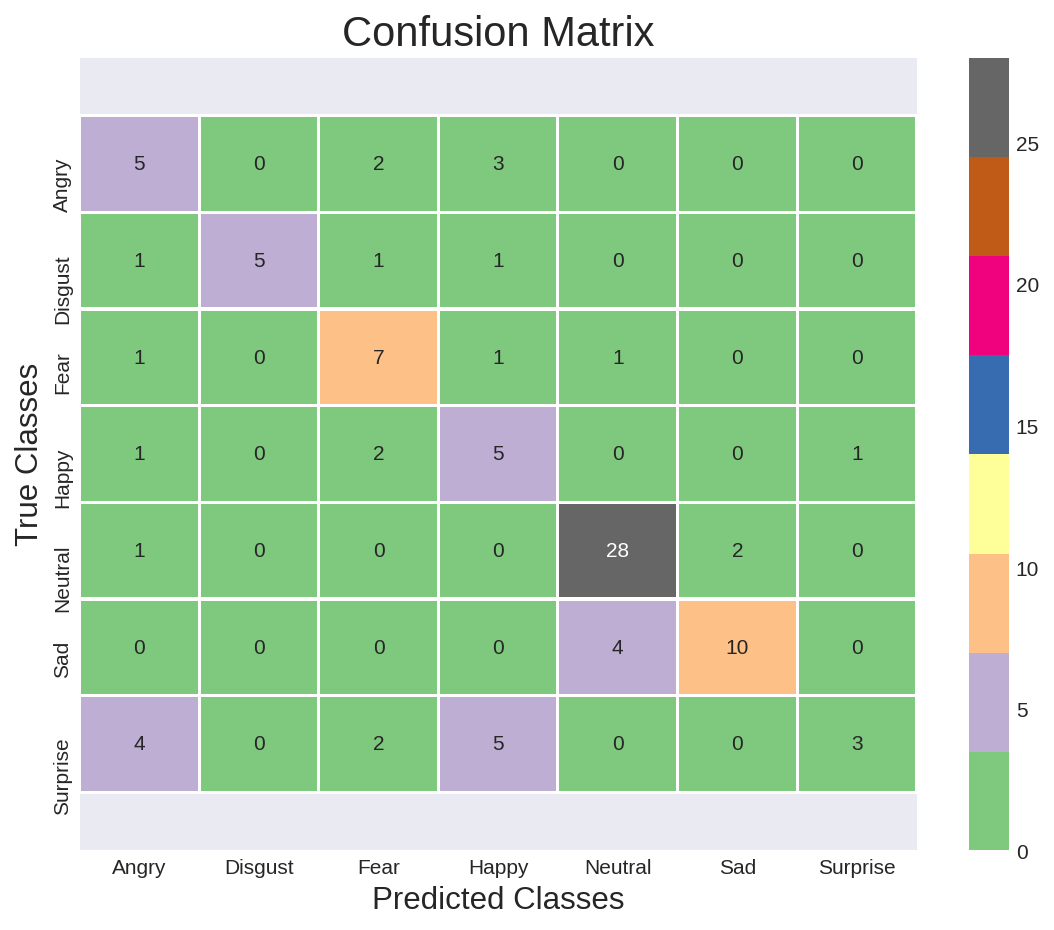

              precision    recall  f1-score   support

       Angry       0.38      0.50      0.43        10
     Disgust       1.00      0.62      0.77         8
        Fear       0.50      0.70      0.58        10
       Happy       0.33      0.56      0.42         9
     Neutral       0.85      0.90      0.88        31
         Sad       0.83      0.71      0.77        14
    Surprise       0.75      0.21      0.33        14

    accuracy                           0.66        96
   macro avg       0.66      0.60      0.60        96
weighted avg       0.71      0.66      0.65        96



In [22]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS 
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs') 
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss') 
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model2.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']))  

In [29]:
model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.GRU(512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(7, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model3.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model3.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model3.save('/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/model3-GRU-savee-without-augmentation.hdf5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_79 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 37, 256)          

3/3 [==============================] - 1s 17ms/step - loss: 3.3951 - accuracy: 0.6771
Loss of the model is -  3.3951079845428467
3/3 [==============================] - 0s 15ms/step - loss: 3.3951 - accuracy: 0.6771
Accuracy of the model is -  67.70833134651184 %


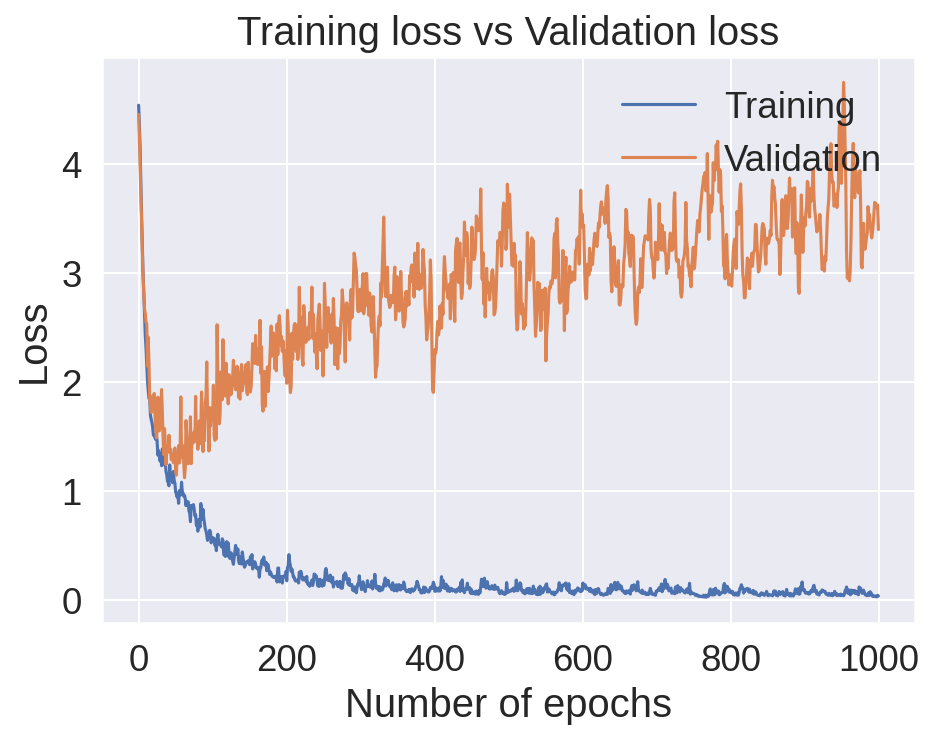

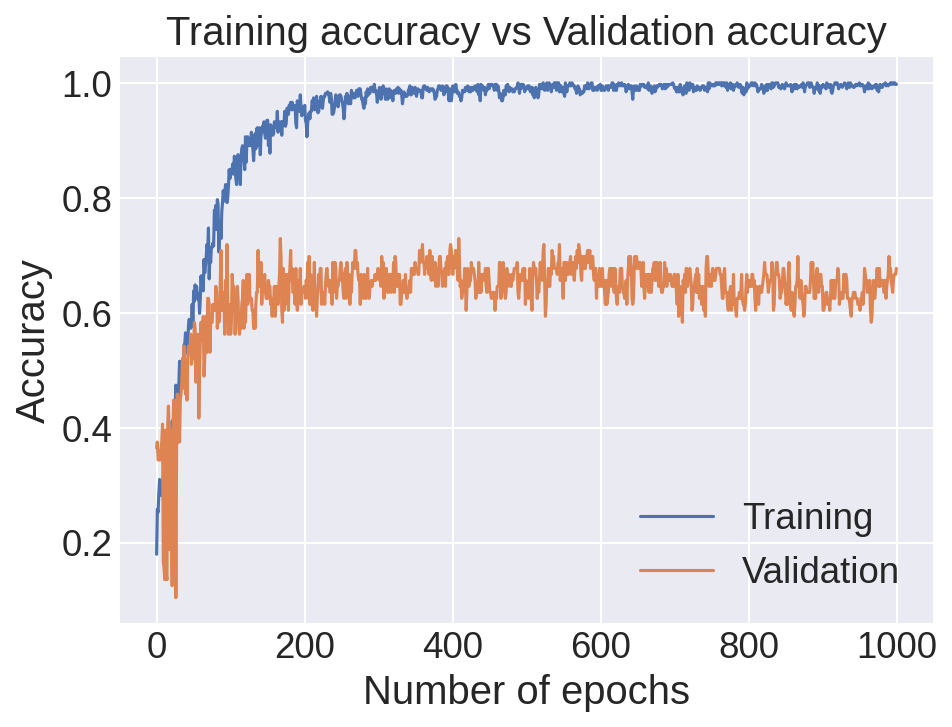

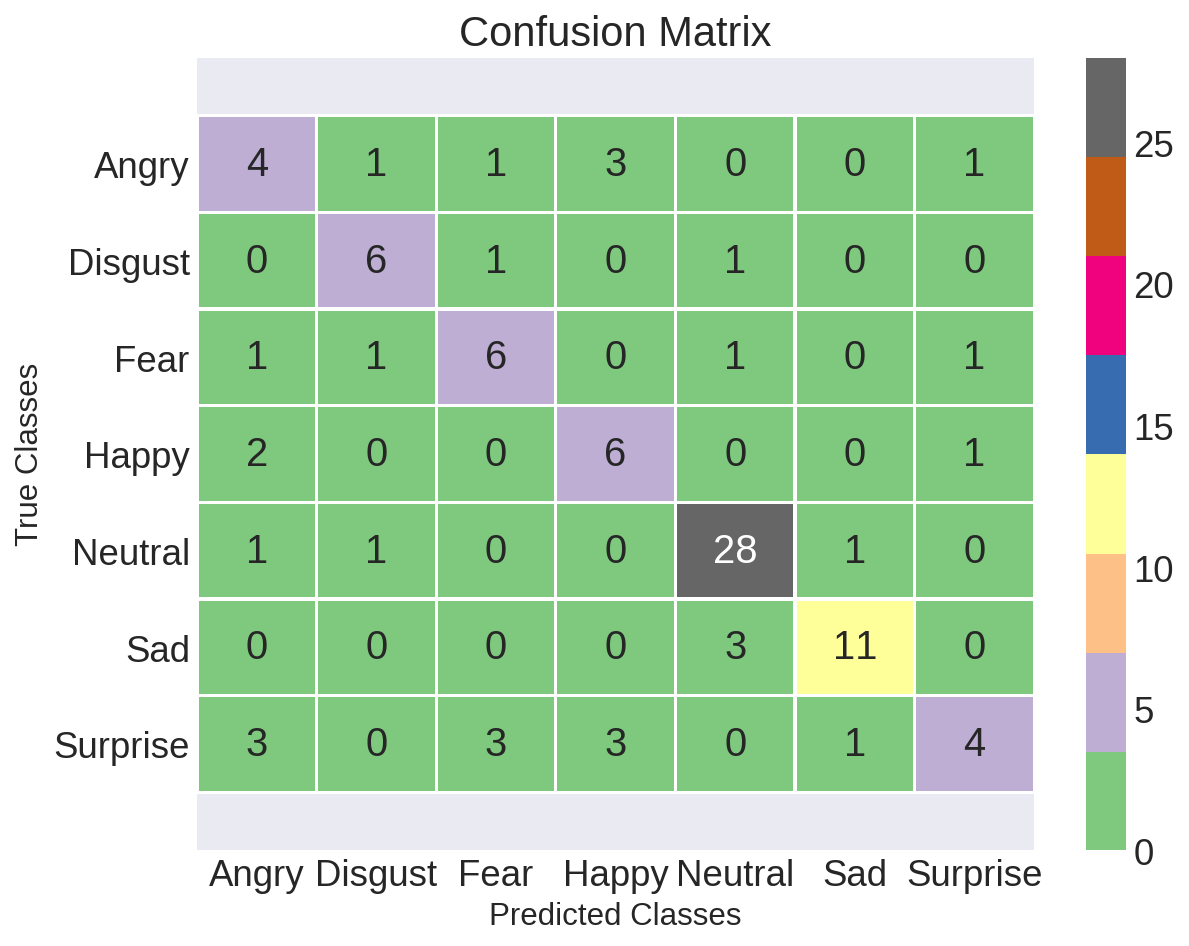

              precision    recall  f1-score   support

       Angry       0.36      0.40      0.38        10
     Disgust       0.67      0.75      0.71         8
        Fear       0.55      0.60      0.57        10
       Happy       0.50      0.67      0.57         9
     Neutral       0.85      0.90      0.88        31
         Sad       0.85      0.79      0.81        14
    Surprise       0.57      0.29      0.38        14

    accuracy                           0.68        96
   macro avg       0.62      0.63      0.61        96
weighted avg       0.68      0.68      0.67        96



In [31]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS 
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs') 
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss') 
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model3.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model3.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model3.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']))  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score for model1 =  0.6770833333333334
Accuracy Score for model2 =  0.65625
Accuracy Score for model3 =  0.6770833333333334
Accuracy Score for average ensemble =  0.6979166666666666
Weighted average method
Accuracy Score for model1 =  0.6770833333333334
Accuracy Score for model2 =  0.65625
Accuracy Score for model3 =  0.6770833333333334
Accuracy Score for average ensemble =  0.6979166666666666
Accuracy Score for weighted average ensemble =  0.7083333333333334
Max accuracy of  70.83333333333334  obained with w1= 0.2  w2= 0.1  and w3= 0.2


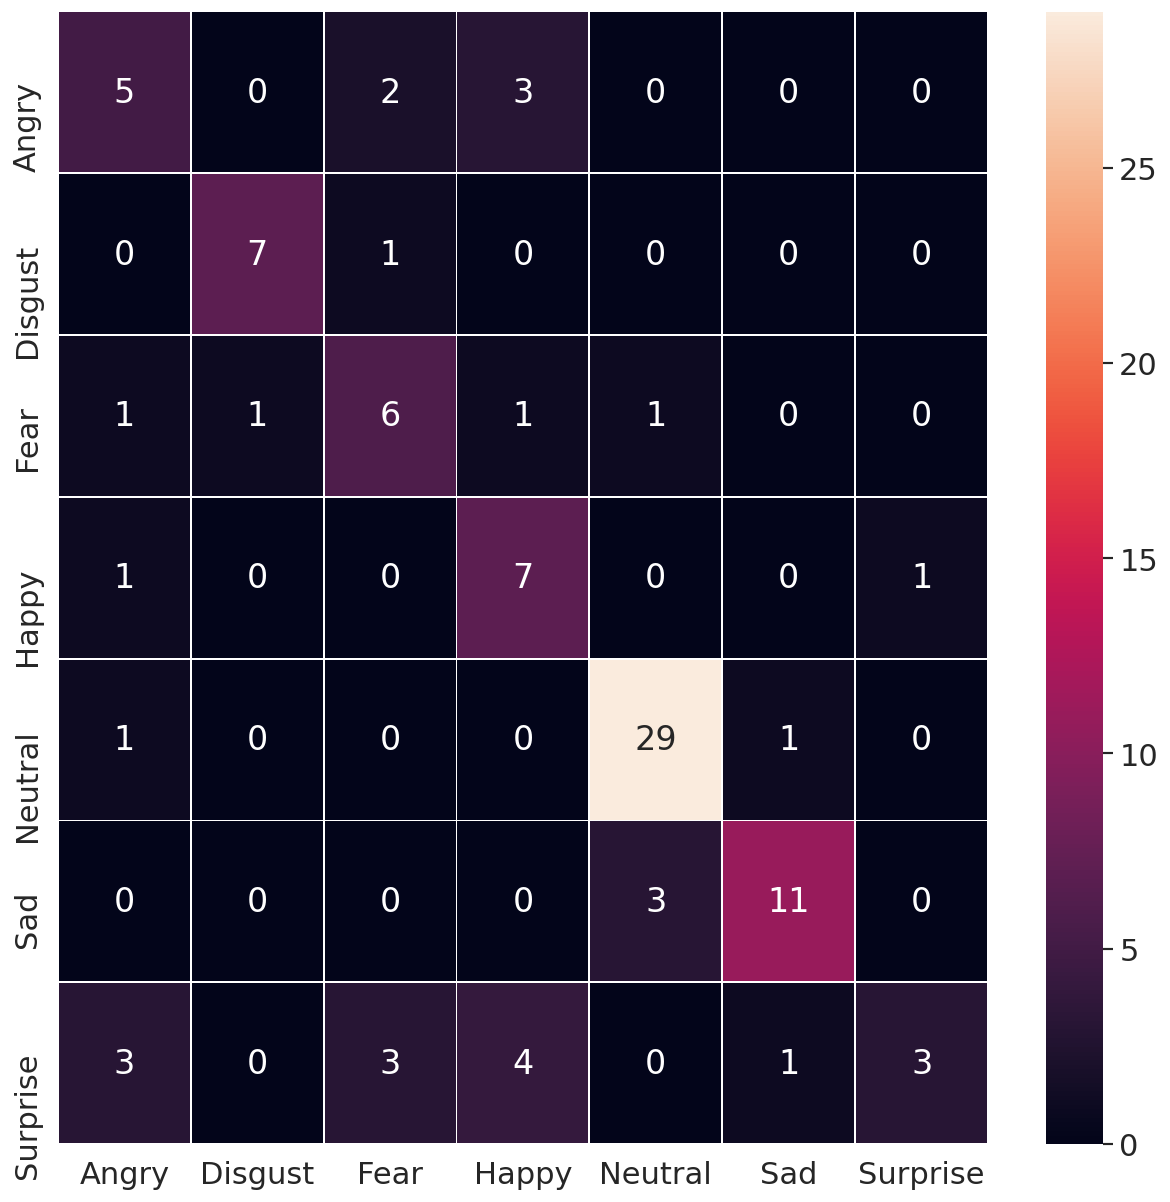

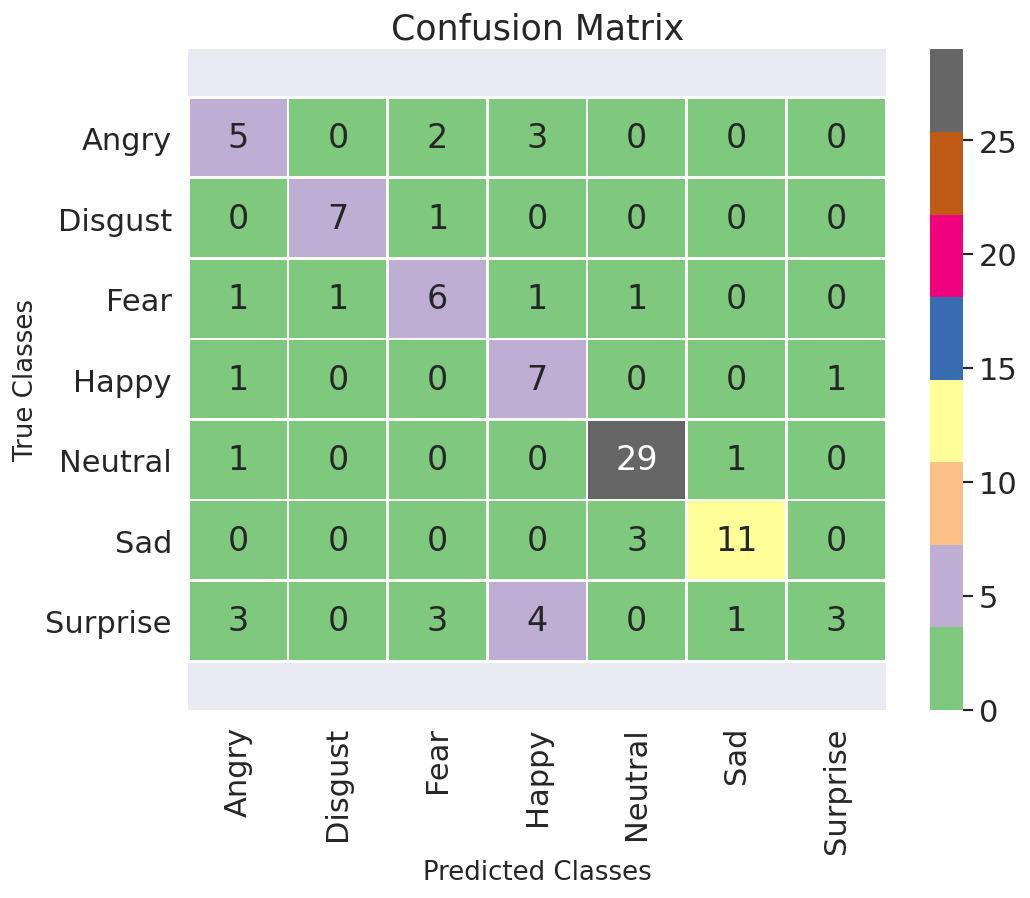

In [33]:
import random
#########################################################################
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/model1-CNN-savee-without-augmentation.hdf5')
model2 = load_model('/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/model2-LSTM-savee-without-augmentation.hdf5')
model3 = load_model('/content/drive/MyDrive/Speech Emotion analysis/SAVEE_DATASET/model3-GRU-savee-without-augmentation.hdf5')

models = [model1, model2, model3]

preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict_classes(x_test)
prediction2 = model2.predict_classes(x_test)
prediction3 = model3.predict_classes(x_test)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), prediction3)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

########################################
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])         


###########################################################################
### Explore metrics for the ideal weighted ensemble model. 

models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [0.2, 0.1, 0.2] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-2.png')
plt.show() 